Целевая переменная: interest
group: {'1': 0, '11': 1, '12': 2, '13': 3, '2': 4, '3': 5, '4': 6, '8': 7}
stream: {'Информатика': 0, 'Прикладная информатика': 1, 'Прикладная математика': 2}
sex: {'Ж': 0, 'М': 1}
os: {'Linux': 0, 'MacOS': 1, 'Windows': 2}
work_experience: {'1-2 года': 0, 'Меньше года': 1, 'Не работаю': 2, 'более 2 лет': 3}
ai: {'ChatGPT': 0, 'Claude': 1, 'Copilot': 2, 'Cursor': 3, 'DeepSeek': 4, 'Gemini': 5, 'Gemini от Google': 6, 'Grok': 7, 'Mistral': 8, 'Qwen': 9, 'claude': 10, 'gpt oss 120b': 11, 'дядя Степа aka Каланча': 12}
social: {'Интроверт': 0, 'Социофоб': 1, 'Экстраверт': 2}
sport: {'Вообще нет': 0, 'Да, я спортсмен': 1, 'Редко, легкая физкультура': 2}
eye_color: {'Голубые': 0, 'Зеленые': 1, 'Карие': 2, 'Серые': 3}
hostel: {'Да': 0, 'Нет, я из Минска': 1, 'Нет, я из регионов': 2}

Всего доступных признаков: 15
Признаки: ['age', 'height', 'score', 'foot_size', 'miss', 'group_encoded', 'stream_encoded', 'sex_encoded', 'os_encoded', 'work_experience_encoded', 'ai_e

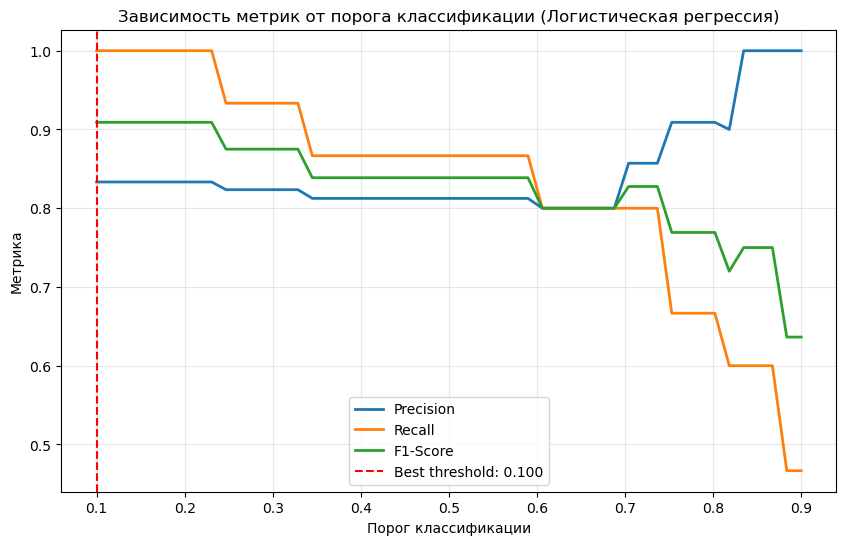


Логистическая регрессия:
Accuracy:  0.8000
Precision: 0.8000
Recall:    1.0000
ROC-AUC:   0.2812
Confusion Matrix:
[[ 0  4]
 [ 0 16]]

СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                 Model  Accuracy  Precision  Recall  ROC-AUC
0              Trivial      0.80     0.8000  1.0000   0.5000
1          Naive Bayes      0.65     0.7647  0.8125   0.3125
2                  KNN      0.75     0.7895  0.9375   0.4688
3  Logistic Regression      0.80     0.8000  1.0000   0.2812


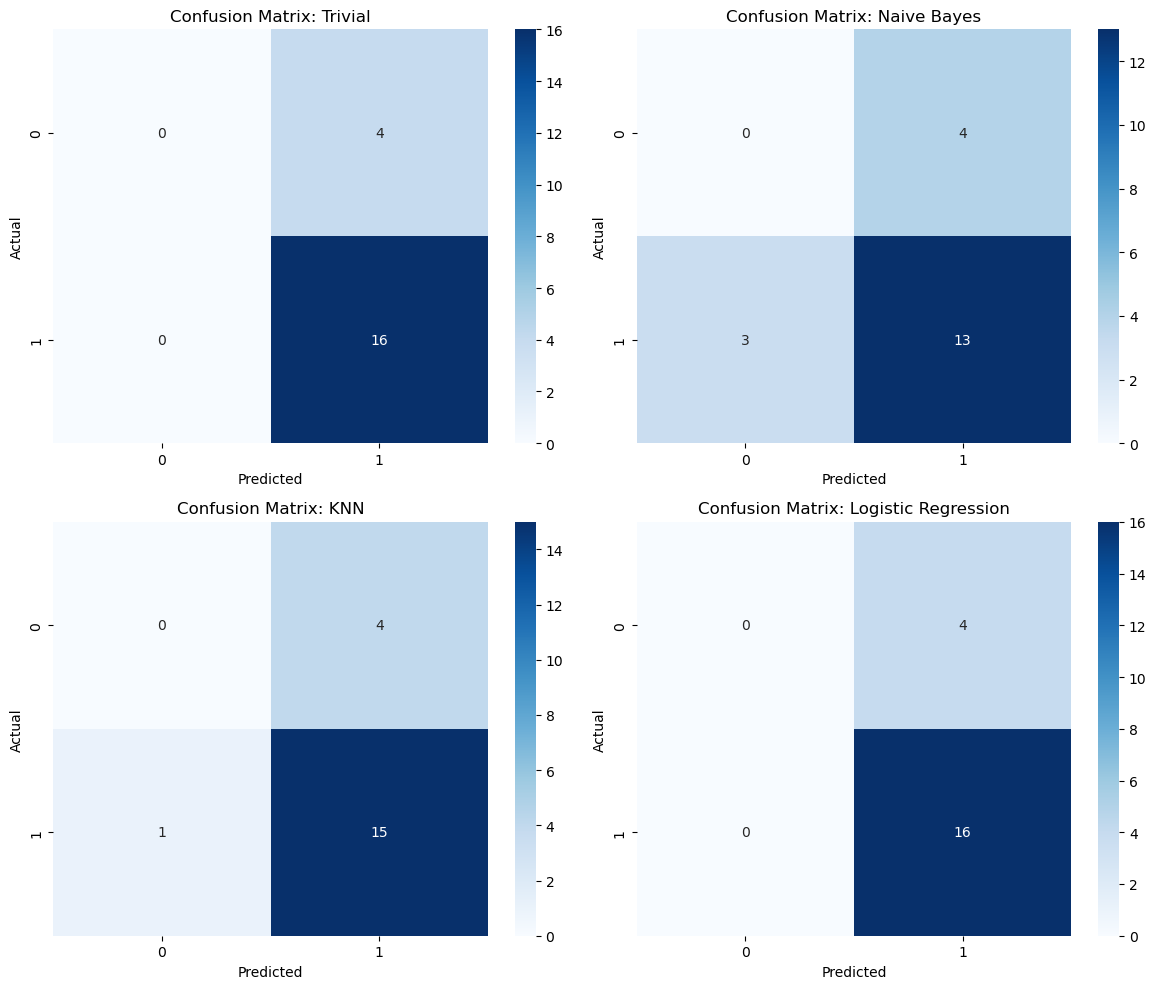


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (Логистическая регрессия)
                   Feature    Weight  Abs_Weight
2                    score -1.847695    1.847695
1                   height  1.556577    1.556577
5            group_encoded  0.945108    0.945108
4                     miss -0.838618    0.838618
6           stream_encoded  0.806378    0.806378
7              sex_encoded -0.599063    0.599063
0                      age -0.424233    0.424233
3                foot_size -0.282814    0.282814
8               os_encoded -0.208213    0.208213
9  work_experience_encoded -0.162726    0.162726


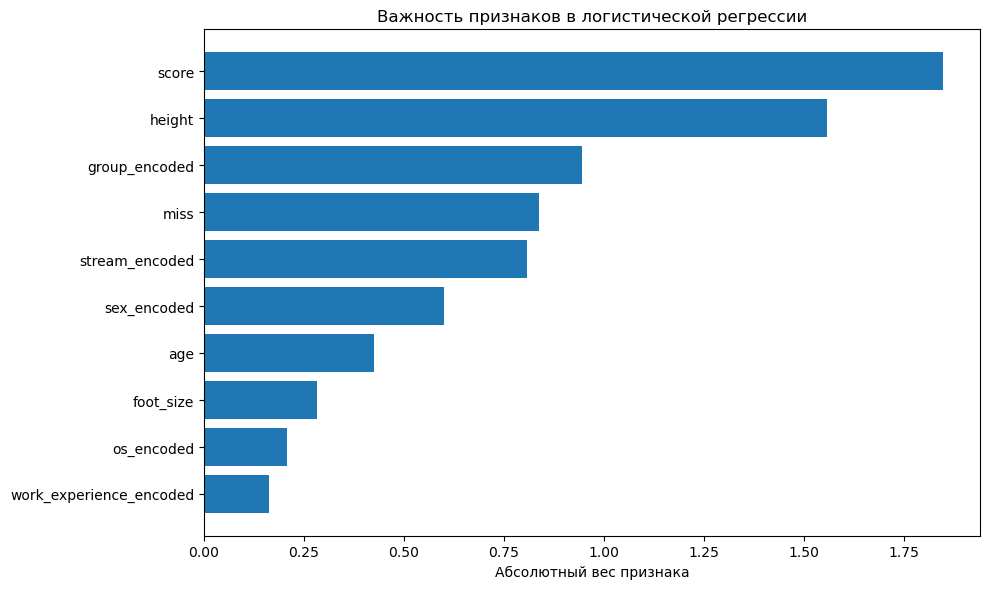

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('./famcs_students.csv')

N = 17
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[N % 8]

print(f"Целевая переменная: {target_col}")

# Преобразование категориальных признаков в числовые
df_encoded = df.copy()

# Сначала убедимся, что целевая переменная числовая
if df_encoded[target_col].dtype == 'object':
    le_target = LabelEncoder()
    df_encoded[target_col] = le_target.fit_transform(df_encoded[target_col])

# Словари для кодирования категориальных признаков
encoding_dict = {}

# Кодируем категориальные признаки
categorical_cols = ['group', 'stream', 'sex', 'os', 'work_experience', 'ai', 'social', 'sport', 'eye_color', 'hostel']

for col in categorical_cols:
    if col in df_encoded.columns:
        # Заменяем строки на числовые коды
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
        encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"{col}: {encoding_dict[col]}")

# Выбор признаков (числовые + закодированные категориальные)
numeric_features = ['age', 'height', 'course', 'score', 'foot_size', 'miss']

# Проверяем, какие числовые признаки действительно существуют и являются числовыми
available_numeric = []
for feature in numeric_features:
    if feature in df_encoded.columns:
        # Преобразуем в числовой тип, игнорируя ошибки
        df_encoded[feature] = pd.to_numeric(df_encoded[feature], errors='coerce')
        available_numeric.append(feature)

encoded_features = [col + '_encoded' for col in categorical_cols if col in df_encoded.columns]

# Все доступные признаки
all_available_features = available_numeric + encoded_features

print(f"\nВсего доступных признаков: {len(all_available_features)}")
print(f"Признаки: {all_available_features}")

# Выбираем признаки
selected_features = all_available_features[:10] if len(all_available_features) >= 10 else all_available_features
print(f"\nВыбранные признаки для модели: {selected_features}")

# Подготовка данных - заполняем пропуски и убеждаемся, что все числовые
X = df_encoded[selected_features].copy()

# Заполняем пропуски медианами
for col in selected_features:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)
    
    # Убеждаемся, что данные числовые
    X[col] = pd.to_numeric(X[col], errors='coerce')
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

y = df_encoded[target_col]

# Убедимся, что y тоже числовой
y = pd.to_numeric(y, errors='coerce')
if y.isnull().any():
    y.fillna(y.mode()[0] if len(y.mode()) > 0 else 0, inplace=True)

# Разделение на тренировочную, валидационную и тестовую выборки
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f"\nРазмеры выборок: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
print(f"Распределение целевой переменной: {y.value_counts().to_dict()}")



# Классы моделей
class TrivialClassifier:
    def __init__(self):
        self.most_frequent_class = None
    
    def fit(self, X, y):
        self.most_frequent_class = y.mode()[0]
        return self
    
    def predict(self, X):
        return np.array([self.most_frequent_class] * len(X))

class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.feature_params = {}
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        
        for c in self.classes:
            self.class_priors[c] = np.mean(y == c)
        
        self.feature_params = {}
        for feature in X.columns:
            self.feature_params[feature] = {}
            for c in self.classes:
                feature_values = X[y == c][feature]
                self.feature_params[feature][c] = {
                    'mean': np.mean(feature_values),
                    'std': np.std(feature_values) + 1e-6
                }
        return self
    
    def _gaussian_pdf(self, x, mean, std):
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    def predict_proba(self, X):
        probabilities = []
        for _, sample in X.iterrows():
            class_probs = {}
            for c in self.classes:
                log_prob = np.log(self.class_priors[c])
                
                for feature in X.columns:
                    mean = self.feature_params[feature][c]['mean']
                    std = self.feature_params[feature][c]['std']
                    prob = self._gaussian_pdf(sample[feature], mean, std)
                    log_prob += np.log(prob + 1e-10)
                
                class_probs[c] = np.exp(log_prob)
            
            total_prob = sum(class_probs.values())
            for c in class_probs:
                class_probs[c] /= total_prob
            
            probabilities.append([class_probs.get(0, 0), class_probs.get(1, 0)])
        
        return np.array(probabilities)
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= threshold).astype(int)

class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X.values
        self.y_train = y.values
        return self
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        predictions = []
        for x in X.values:
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            most_common = np.bincount(k_nearest_labels).argmax()
            predictions.append(most_common)
        
        return np.array(predictions)

class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        
        return self
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

# Функции для оценки качества
def evaluate_model(model, X, y, model_name, threshold=0.5):
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        roc_auc = roc_auc_score(y, y_pred_proba)
    else:
        y_pred = model.predict(X)
        roc_auc = roc_auc_score(y, y_pred)
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    cm = confusion_matrix(y, y_pred)
    
    print(f"\n{model_name}:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

# Обучение и оценка моделей
print("=" * 50)
print("ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ")
print("=" * 50)

# Тривиальный классификатор
trivial_model = TrivialClassifier().fit(X_train, y_train)
trivial_metrics = evaluate_model(trivial_model, X_test, y_test, "Тривиальный классификатор")

# Наивный Байес
nb_model = NaiveBayesClassifier().fit(X_train, y_train)
nb_metrics = evaluate_model(nb_model, X_test, y_test, "Наивный Байес")

# KNN - подбор оптимального k
print("\nПодбор оптимального k для KNN:")
best_k = 3
best_accuracy = 0
for k in [3, 5, 7, 9, 11]:
    knn_temp = KNNClassifier(k=k).fit(X_train, y_train)
    y_pred_val = knn_temp.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f"k={k}, Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Выбранный k: {best_k}")
knn_model = KNNClassifier(k=best_k).fit(X_train, y_train)
knn_metrics = evaluate_model(knn_model, X_test, y_test, "KNN классификатор")

# 3. Логистическая регрессия - подбор порога
print("\nПодбор порога для логистической регрессии:")

# Нормализация данных для логистической регрессии
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(learning_rate=0.1, n_iter=2000).fit(X_train_scaled, y_train.values)

# Подбор порога по валидационной выборке
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

y_val_proba = lr_model.predict_proba(X_val_scaled)

for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Лучший порог: {best_threshold:.3f}")

# График зависимости метрик от порога
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от порога классификации (Логистическая регрессия)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Оценка логистической регрессии с лучшим порогом
lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test, "Логистическая регрессия", threshold=best_threshold)

# Сравнительная таблица результатов
results = pd.DataFrame({
    'Model': ['Trivial', 'Naive Bayes', 'KNN', 'Logistic Regression'],
    'Accuracy': [trivial_metrics['accuracy'], nb_metrics['accuracy'], knn_metrics['accuracy'], lr_metrics['accuracy']],
    'Precision': [trivial_metrics['precision'], nb_metrics['precision'], knn_metrics['precision'], lr_metrics['precision']],
    'Recall': [trivial_metrics['recall'], nb_metrics['recall'], knn_metrics['recall'], lr_metrics['recall']],
    'ROC-AUC': [trivial_metrics['roc_auc'], nb_metrics['roc_auc'], knn_metrics['roc_auc'], lr_metrics['roc_auc']]
})

print("\n" + "=" * 60)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 60)
print(results.round(4))

# Визуализация матриц ошибок
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
models = [trivial_model, nb_model, knn_model, lr_model]
model_names = ['Trivial', 'Naive Bayes', 'KNN', 'Logistic Regression']
datasets = [X_test, X_test, X_test, X_test_scaled]
thresholds_list = [0.5, 0.5, 0.5, best_threshold]

for i, (model, name, data, threshold) in enumerate(zip(models, model_names, datasets, thresholds_list)):
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(data)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(data)
    
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i//2, i%2]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Анализ важности признаков (для логистической регрессии)
print("\n" + "=" * 50)
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (Логистическая регрессия)")
print("=" * 50)

feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Weight': lr_model.weights
})
feature_importance['Abs_Weight'] = np.abs(feature_importance['Weight'])
feature_importance = feature_importance.sort_values('Abs_Weight', ascending=False)

print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Weight'])
plt.xlabel('Абсолютный вес признака')
plt.title('Важность признаков в логистической регрессии')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
